<a href="https://colab.research.google.com/github/diegoeller/Churn-Prediction-Project/blob/main/Telco_Customer_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Loading libraries and data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import shap

In [2]:
# Carregar dataset (Exemplo: Telco Customer Churn)
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

#3. Understanding the data

In [3]:
# Get the number of rows and columns
num_rows = df.shape[0]
num_cols = df.shape[1]

# Print the information in the specified format
print(f"The dataset has {num_rows} rows and {num_cols} columns.")

The dataset has 7043 rows and 21 columns.


In [4]:
# Verificar os primeiros dados
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


#4. Data Manipulation

In [6]:
# Convertendo colunas para numéricas
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['MonthlyCharges'] = pd.to_numeric(df['MonthlyCharges'], errors='coerce')

##4.1. Visualizing missing values

In [7]:
df.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


Here we see that the TotalCharges has 11 missing values. Let's check this data.

In [8]:
df[np.isnan(df['TotalCharges'])]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


- It can be noted that the Tenure column is 0 for these entries (Months that the customer has been with the company), makes sense the TotalCharges column is missing, even though the MonthlyCharges column is not.
- Let's see if there are any other 0 values in the tenure column.

In [9]:
df[df['tenure'] == 0].index

Index([488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754], dtype='int64')

- There are no additional missing values in the Tenure column.
- Let's delete the rows with missing values in Tenure columns since there are only 11 rows and deleting them will not affect the data.

In [10]:
# Drop rows where 'tenure' is 0
df.drop(df[df['tenure'] == 0].index, axis=0, inplace=True)

# Check for remaining rows with tenure = 0
df[df['tenure'] == 0].index

Index([], dtype='int64')

##4.2. Removing the ID column

- By removing the ID column, we are preparing the dataset for future analysis.
- We can still use the index to count the number of customers.

In [11]:
df = df.drop(['customerID'], axis = 1)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


##4.3. Converting to binary

*Explain*

In [12]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

#5. Data Visualization

## 5.1. Graphics

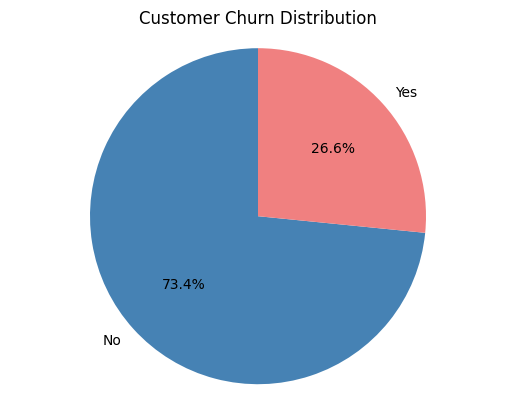

In [54]:
# Create the pizza graphic
fig, ax = plt.subplots()
ax.pie(df['Churn'].value_counts().values,
       labels = ['No', 'Yes'],
       colors=['steelblue', 'lightcoral'],
       autopct='%1.1f%%',
       startangle=90)

ax.set_title('Customer Churn Distribution')
ax.axis('equal')

plt.show()

- 26.6% of customers switched to another firm (Churned).

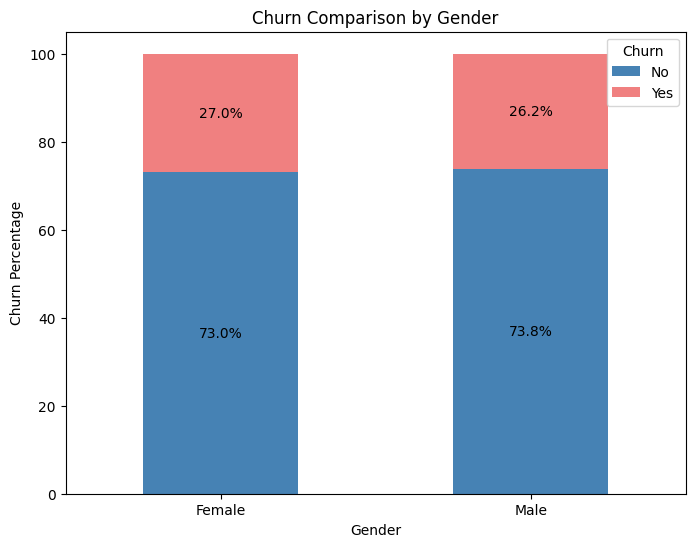

In [75]:
# Calculate churn counts by gender
churn_by_gender = df.groupby('gender')['Churn'].value_counts().unstack()

# The columns are now 0 and 1 representing 'No' and 'Yes' respectively
churn_by_gender = churn_by_gender.rename(columns={0: 'No', 1: 'Yes'})

# Now you can access the columns using 'Yes' and 'No'
churn_by_gender = churn_by_gender[['No', 'Yes']]

# Calculate percentages
churn_percentage = churn_by_gender.div(churn_by_gender.sum(axis=1), axis=0) * 100

# Create the stacked bar plot
ax = churn_percentage.plot(kind='bar',
                           stacked=True,
                           figsize=(8, 6),
                           color=['steelblue', 'lightcoral'])
plt.title('Churn Comparison by Gender')
plt.xlabel('Gender')
plt.ylabel('Churn Percentage')
plt.xticks(rotation=0)
plt.legend(title='Churn', labels=['No', 'Yes'], loc='upper right')

# Add percentage labels inside the bars (may need adjustments for stacked bars)
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.show()

- By comparing both genders the behavior looks similar when it comes to switching to another company (Churn)

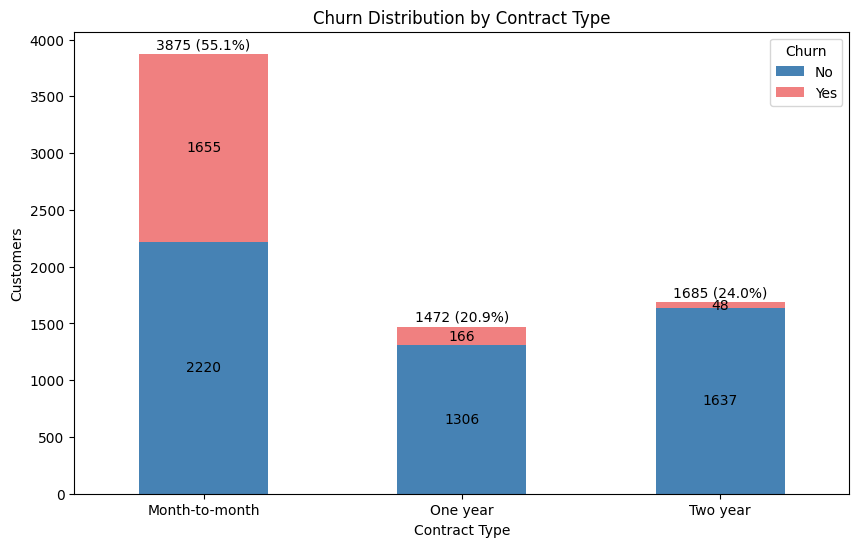

In [111]:
# Calculate churn counts by contract type
churn_by_contract = df.groupby('Contract')['Churn'].value_counts().unstack()

# Rename columns to 'No' and 'Yes' if they are 0 and 1
churn_by_contract = churn_by_contract.rename(columns={0: 'No', 1: 'Yes'}, errors='ignore')

# Create the bar plot with total counts on the Y-axis
ax = churn_by_contract.plot(kind='bar',
                           stacked=True,
                           figsize=(10, 6),
                           color=['steelblue', 'lightcoral'])

plt.title('Churn Distribution by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Customers')
plt.xticks(rotation=0)
plt.legend(title='Churn', labels=['No', 'Yes'], loc='upper right')

# Add total count labels inside the bars
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{int(height)}', (x + width/2, y + height/2), ha='center', va='center')

# Add total count and percentage labels on top of the bars
totals = churn_by_contract.sum(axis=1)  # Calculate total for each contract type
total_customers = totals.sum()  # Calculate total number of customers

for i, total in enumerate(totals):
    percentage = (total / total_customers) * 100  # Calculate percentage
    label = f'{int(total)} ({percentage:.1f}%)'  # Format label with percentage
    ax.text(i, total + 20, label, ha='center', va='bottom')  # Adjust position as needed

plt.show()

- The Month-to-Month contract represents 55% of the total contracts.
- About 43% of customers with a Month-to-Month contract opted to move out, compared to 11% of customers with a One-Year contract and 3% with a Two-Year contract.

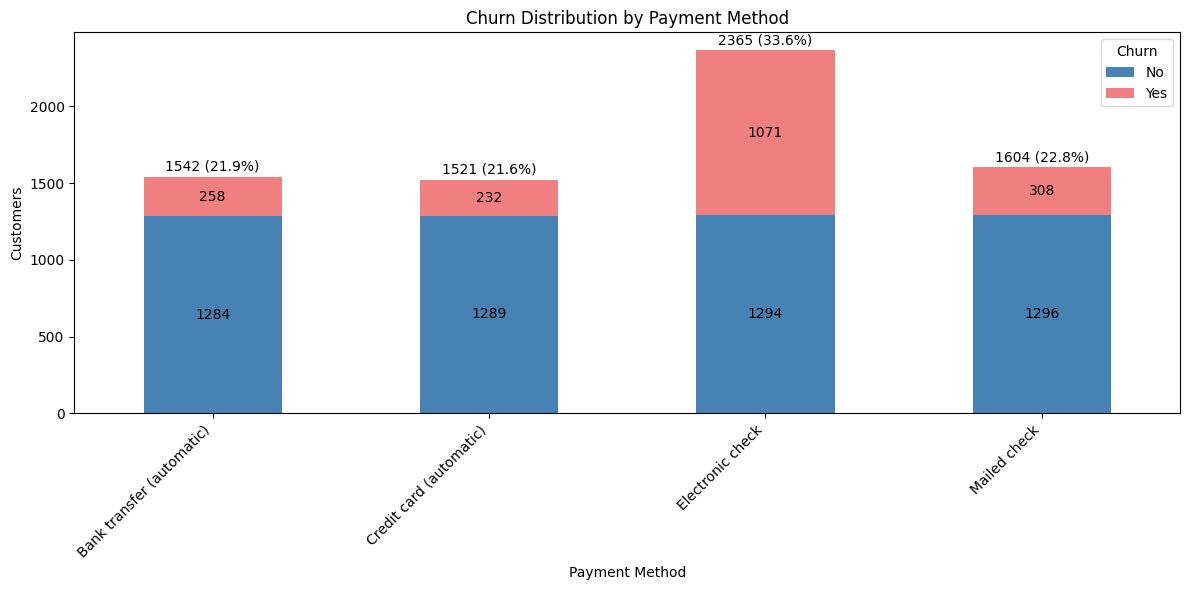

In [115]:
# Calculate churn counts by payment method
churn_by_payment = df.groupby('PaymentMethod')['Churn'].value_counts().unstack()

# Rename columns to 'No' and 'Yes' if they are 0 and 1
churn_by_payment = churn_by_payment.rename(columns={0: 'No', 1: 'Yes'}, errors='ignore')

# Create the bar plot with total counts on the Y-axis
ax = churn_by_payment.plot(kind='bar',
                           stacked=True,
                           figsize=(12, 6),  # Adjust figure size for better visualization
                           color=['steelblue', 'lightcoral'])

plt.title('Churn Distribution by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Customers')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.legend(title='Churn', labels=['No', 'Yes'], loc='upper right')

# Add total count labels inside the bars
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{int(height)}', (x + width/2, y + height/2), ha='center', va='center')

# Add total count and percentage labels on top of the bars
totals = churn_by_payment.sum(axis=1)
total_customers = totals.sum()

for i, total in enumerate(totals):
    percentage = (total / total_customers) * 100
    label = f'{int(total)} ({percentage:.1f}%)'
    ax.text(i, total + 20, label, ha='center', va='bottom')

plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()


- Major customers who moved out were having Electronic Check as Payment Method.
- Customers who opted for Credit-Card automatic transfer or Bank Automatic Transfer and Mailed Check as Payment Method were less likely to move out.

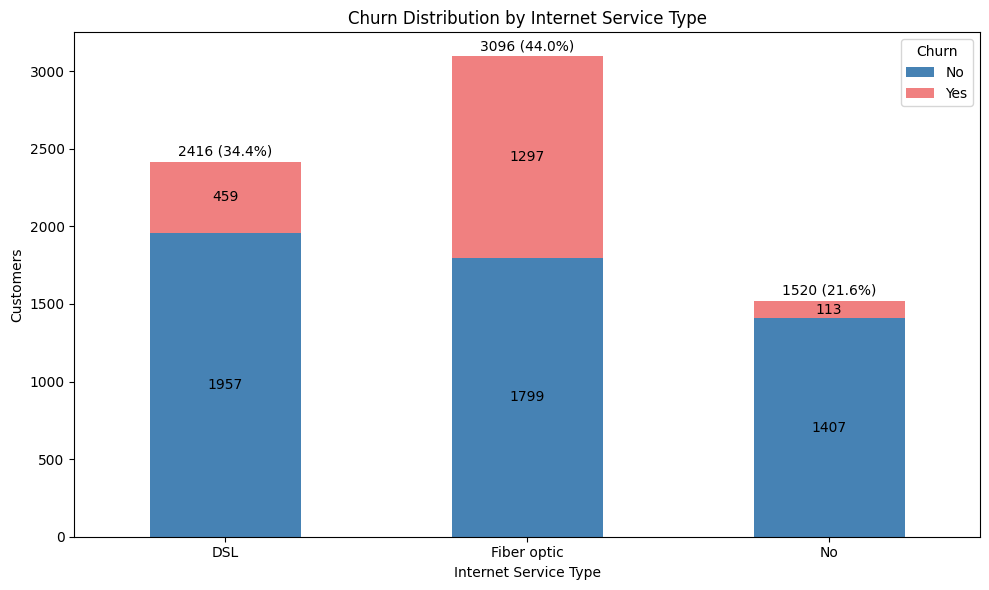

In [117]:
# Calculate churn counts by internet service type
churn_by_internet = df.groupby('InternetService')['Churn'].value_counts().unstack()

# Rename columns to 'No' and 'Yes' if they are 0 and 1
churn_by_internet = churn_by_internet.rename(columns={0: 'No', 1: 'Yes'}, errors='ignore')

# Create the bar plot with total counts on the Y-axis
ax = churn_by_internet.plot(kind='bar',
                            stacked=True,
                            figsize=(10, 6),
                            color=['steelblue', 'lightcoral'])

plt.title('Churn Distribution by Internet Service Type')
plt.xlabel('Internet Service Type')
plt.ylabel('Customers')
plt.xticks(rotation=0)
plt.legend(title='Churn', labels=['No', 'Yes'], loc='upper right')

# Add total count labels inside the bars
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{int(height)}', (x + width/2, y + height/2), ha='center', va='center')

# Add total count and percentage labels on top of the bars
totals = churn_by_internet.sum(axis=1)
total_customers = totals.sum()

for i, total in enumerate(totals):
    percentage = (total / total_customers) * 100
    label = f'{int(total)} ({percentage:.1f}%)'
    ax.text(i, total + 20, label, ha='center', va='bottom')

plt.tight_layout()
plt.show()


- The majority of customers choose the Fiber optic service and it's also evident that the customers who use Fiber optic have high churn rate (42%), this might suggest a dissatisfaction with this type of internet service.

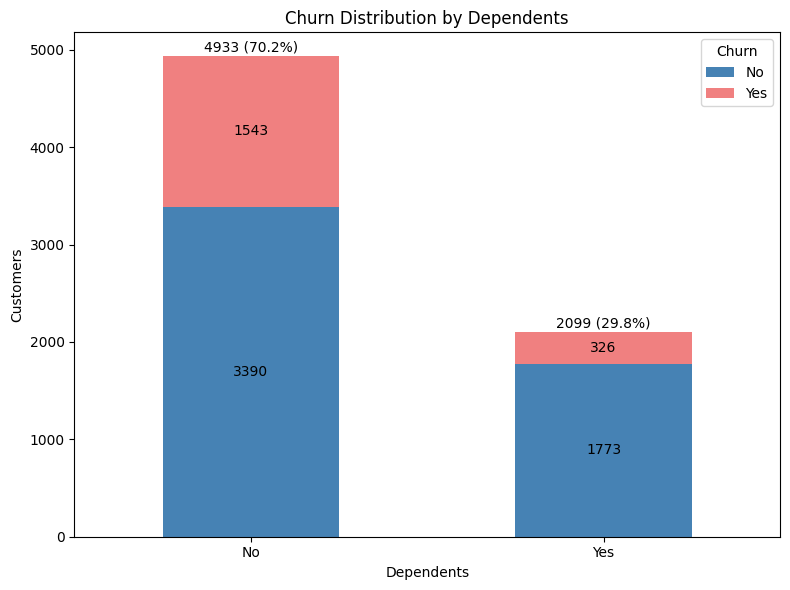

In [118]:
# Calculate churn counts by dependents
churn_by_dependents = df.groupby('Dependents')['Churn'].value_counts().unstack()

# Rename columns to 'No' and 'Yes' if they are 0 and 1
churn_by_dependents = churn_by_dependents.rename(columns={0: 'No', 1: 'Yes'}, errors='ignore')

# Create the bar plot with total counts on the Y-axis
ax = churn_by_dependents.plot(kind='bar',
                              stacked=True,
                              figsize=(8, 6),
                              color=['steelblue', 'lightcoral'])

plt.title('Churn Distribution by Dependents')
plt.xlabel('Dependents')
plt.ylabel('Customers')
plt.xticks(rotation=0)
plt.legend(title='Churn', labels=['No', 'Yes'], loc='upper right')

# Add total count labels inside the bars
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{int(height)}', (x + width/2, y + height/2), ha='center', va='center')

# Add total count and percentage labels on top of the bars
totals = churn_by_dependents.sum(axis=1)
total_customers = totals.sum()

for i, total in enumerate(totals):
    percentage = (total / total_customers) * 100
    label = f'{int(total)} ({percentage:.1f}%)'
    ax.text(i, total + 20, label, ha='center', va='bottom')

plt.tight_layout()
plt.show()


- Customers without dependents are more likely to churn

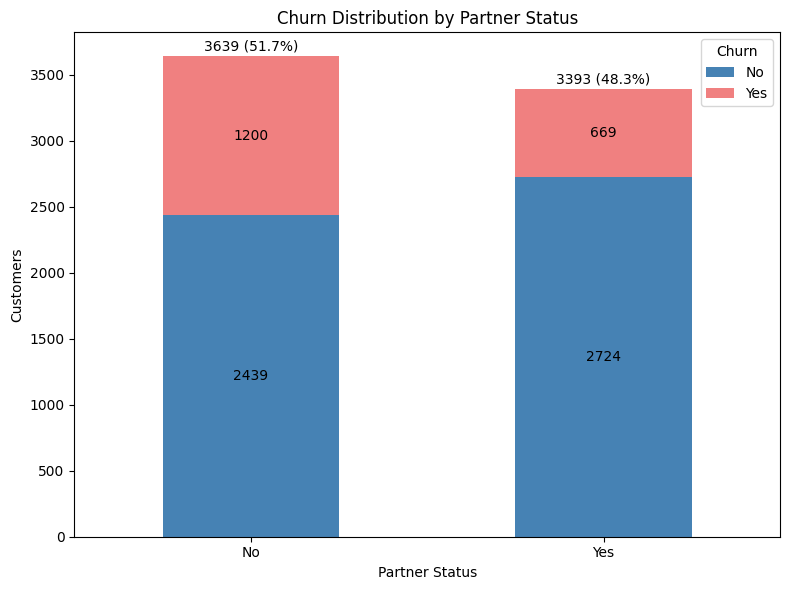

In [119]:
# Calculate churn counts by partner status
churn_by_partner = df.groupby('Partner')['Churn'].value_counts().unstack()

# Rename columns to 'No' and 'Yes' if they are 0 and 1
churn_by_partner = churn_by_partner.rename(columns={0: 'No', 1: 'Yes'}, errors='ignore')

# Create the bar plot with total counts on the Y-axis
ax = churn_by_partner.plot(kind='bar',
                           stacked=True,
                           figsize=(8, 6),
                           color=['steelblue', 'lightcoral'])

plt.title('Churn Distribution by Partner Status')
plt.xlabel('Partner Status')
plt.ylabel('Customers')
plt.xticks(rotation=0)
plt.legend(title='Churn', labels=['No', 'Yes'], loc='upper right')

# Add total count labels inside the bars
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{int(height)}', (x + width/2, y + height/2), ha='center', va='center')

# Add total count and percentage labels on top of the bars
totals = churn_by_partner.sum(axis=1)
total_customers = totals.sum()

for i, total in enumerate(totals):
    percentage = (total / total_customers) * 100
    label = f'{int(total)} ({percentage:.1f}%)'
    ax.text(i, total + 20, label, ha='center', va='bottom')

plt.tight_layout()
plt.show()


- Customers that doesn't have partners are more likely to churn

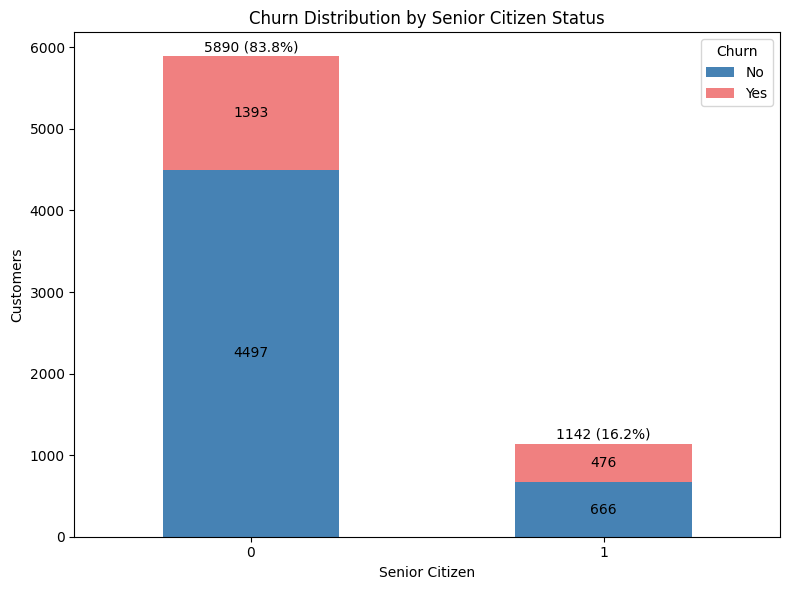

In [120]:
# Calculate churn counts by senior citizen status
churn_by_senior_citizen = df.groupby('SeniorCitizen')['Churn'].value_counts().unstack()

# Rename columns to 'No' and 'Yes' if they are 0 and 1
churn_by_senior_citizen = churn_by_senior_citizen.rename(columns={0: 'No', 1: 'Yes'}, errors='ignore')

# Create the bar plot with total counts on the Y-axis
ax = churn_by_senior_citizen.plot(kind='bar',
                                 stacked=True,
                                 figsize=(8, 6),
                                 color=['steelblue', 'lightcoral'])

plt.title('Churn Distribution by Senior Citizen Status')
plt.xlabel('Senior Citizen')
plt.ylabel('Customers')
plt.xticks(rotation=0)
plt.legend(title='Churn', labels=['No', 'Yes'], loc='upper right')

# Add total count labels inside the bars
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{int(height)}', (x + width/2, y + height/2), ha='center', va='center')

# Add total count and percentage labels on top of the bars
totals = churn_by_senior_citizen.sum(axis=1)
total_customers = totals.sum()

for i, total in enumerate(totals):
    percentage = (total / total_customers) * 100
    label = f'{int(total)} ({percentage:.1f}%)'
    ax.text(i, total + 20, label, ha='center', va='bottom')

plt.tight_layout()
plt.show()


- Although senior citizens are not very numerous (16%), they have a 42% churn rate. Compared to non-senior citizens with 24% churn rate, they are substantially more likely to churn.

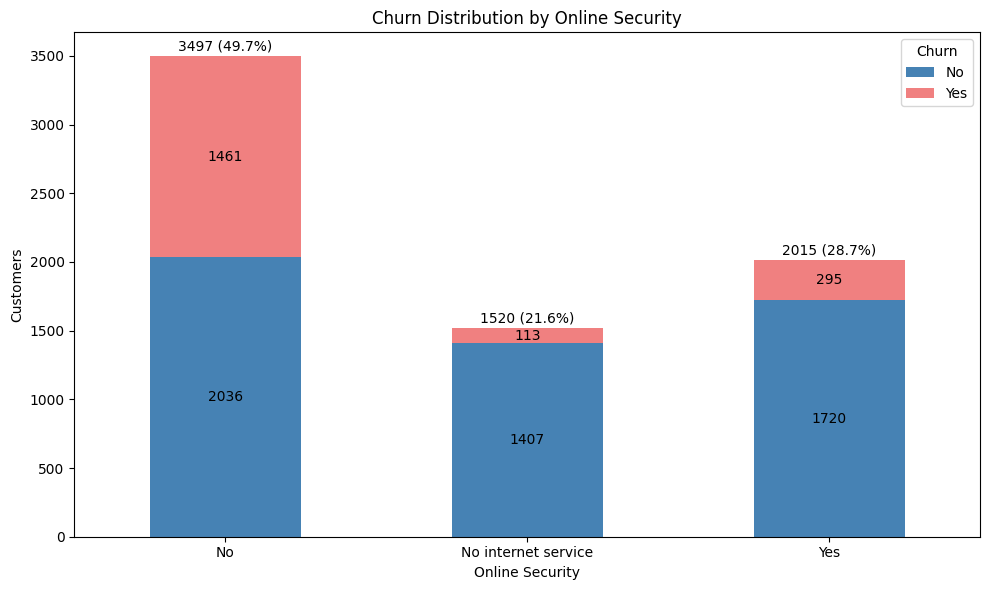

In [121]:
# Calculate churn counts by online security
churn_by_online_security = df.groupby('OnlineSecurity')['Churn'].value_counts().unstack()

# Rename columns to 'No' and 'Yes' if they are 0 and 1
churn_by_online_security = churn_by_online_security.rename(columns={0: 'No', 1: 'Yes'}, errors='ignore')

# Create the bar plot with total counts on the Y-axis
ax = churn_by_online_security.plot(kind='bar',
                                   stacked=True,
                                   figsize=(10, 6),
                                   color=['steelblue', 'lightcoral'])

plt.title('Churn Distribution by Online Security')
plt.xlabel('Online Security')
plt.ylabel('Customers')
plt.xticks(rotation=0)
plt.legend(title='Churn', labels=['No', 'Yes'], loc='upper right')

# Add total count labels inside the bars
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{int(height)}', (x + width/2, y + height/2), ha='center', va='center')

# Add total count and percentage labels on top of the bars
totals = churn_by_online_security.sum(axis=1)
total_customers = totals.sum()

for i, total in enumerate(totals):
    percentage = (total / total_customers) * 100
    label = f'{int(total)} ({percentage:.1f}%)'
    ax.text(i, total + 20, label, ha='center', va='bottom')

plt.tight_layout()
plt.show()


- Most customers churn in the absence of online security

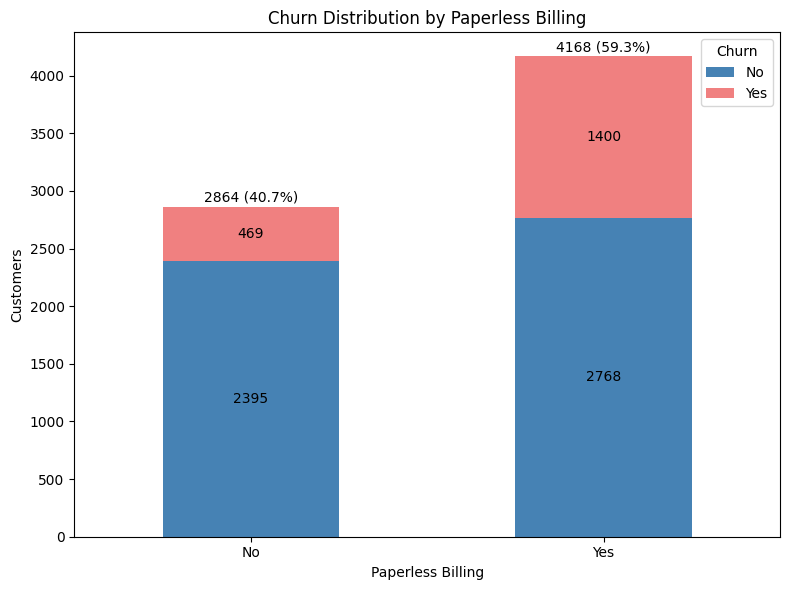

In [122]:
# Calculate churn counts by paperless billing
churn_by_paperless = df.groupby('PaperlessBilling')['Churn'].value_counts().unstack()

# Rename columns to 'No' and 'Yes' if they are 0 and 1
churn_by_paperless = churn_by_paperless.rename(columns={0: 'No', 1: 'Yes'}, errors='ignore')

# Create the bar plot with total counts on the Y-axis
ax = churn_by_paperless.plot(kind='bar',
                             stacked=True,
                             figsize=(8, 6),
                             color=['steelblue', 'lightcoral'])

plt.title('Churn Distribution by Paperless Billing')
plt.xlabel('Paperless Billing')
plt.ylabel('Customers')
plt.xticks(rotation=0)
plt.legend(title='Churn', labels=['No', 'Yes'], loc='upper right')

# Add total count labels inside the bars
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{int(height)}', (x + width/2, y + height/2), ha='center', va='center')

# Add total count and percentage labels on top of the bars
totals = churn_by_paperless.sum(axis=1)
total_customers = totals.sum()

for i, total in enumerate(totals):
    percentage = (total / total_customers) * 100
    label = f'{int(total)} ({percentage:.1f}%)'
    ax.text(i, total + 20, label, ha='center', va='bottom')

plt.tight_layout()
plt.show()


- Customers with Paperless Billing are most likely to churn.

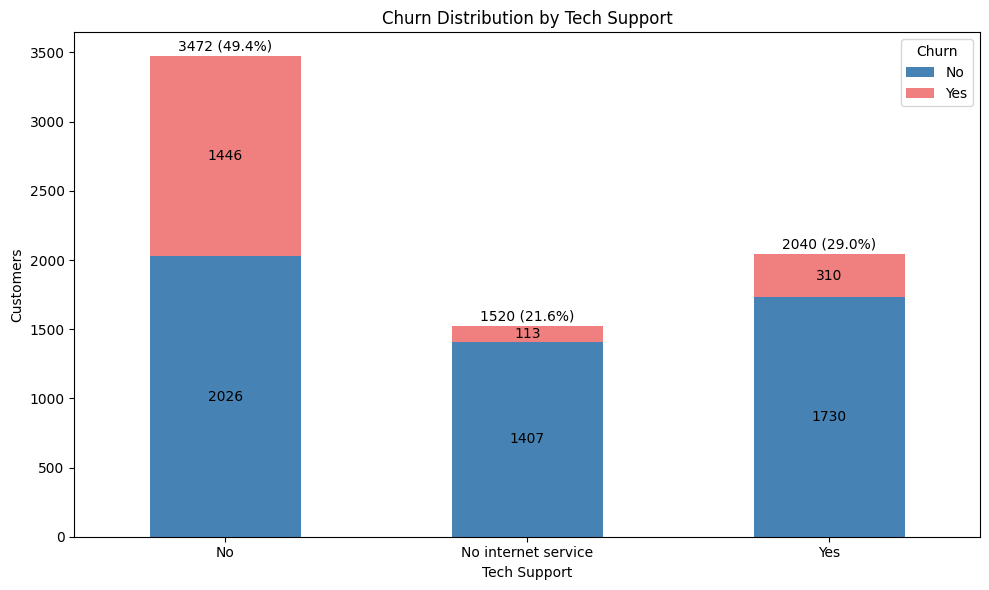

In [123]:
# Calculate churn counts by tech support
churn_by_tech_support = df.groupby('TechSupport')['Churn'].value_counts().unstack()

# Rename columns to 'No' and 'Yes' if they are 0 and 1
churn_by_tech_support = churn_by_tech_support.rename(columns={0: 'No', 1: 'Yes'}, errors='ignore')

# Create the bar plot with total counts on the Y-axis
ax = churn_by_tech_support.plot(kind='bar',
                                stacked=True,
                                figsize=(10, 6),
                                color=['steelblue', 'lightcoral'])

plt.title('Churn Distribution by Tech Support')
plt.xlabel('Tech Support')
plt.ylabel('Customers')
plt.xticks(rotation=0)
plt.legend(title='Churn', labels=['No', 'Yes'], loc='upper right')

# Add total count labels inside the bars
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{int(height)}', (x + width/2, y + height/2), ha='center', va='center')

# Add total count and percentage labels on top of the bars
totals = churn_by_tech_support.sum(axis=1)
total_customers = totals.sum()

for i, total in enumerate(totals):
    percentage = (total / total_customers) * 100
    label = f'{int(total)} ({percentage:.1f}%)'
    ax.text(i, total + 20, label, ha='center', va='bottom')

plt.tight_layout()
plt.show()


- Customers with no TechSupport are most likely to migrate to another service provider.

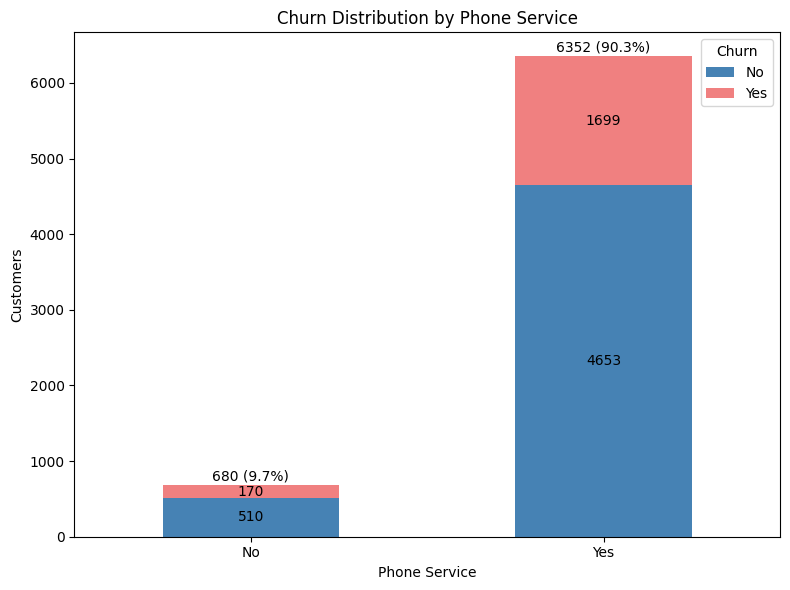

In [124]:
# Calculate churn counts by phone service
churn_by_phone = df.groupby('PhoneService')['Churn'].value_counts().unstack()

# Rename columns to 'No' and 'Yes' if they are 0 and 1
churn_by_phone = churn_by_phone.rename(columns={0: 'No', 1: 'Yes'}, errors='ignore')

# Create the bar plot with total counts on the Y-axis
ax = churn_by_phone.plot(kind='bar',
                         stacked=True,
                         figsize=(8, 6),
                         color=['steelblue', 'lightcoral'])

plt.title('Churn Distribution by Phone Service')
plt.xlabel('Phone Service')
plt.ylabel('Customers')
plt.xticks(rotation=0)
plt.legend(title='Churn', labels=['No', 'Yes'], loc='upper right')

# Add total count labels inside the bars
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{int(height)}', (x + width/2, y + height/2), ha='center', va='center')

# Add total count and percentage labels on top of the bars
totals = churn_by_phone.sum(axis=1)
total_customers = totals.sum()

for i, total in enumerate(totals):
    percentage = (total / total_customers) * 100
    label = f'{int(total)} ({percentage:.1f}%)'
    ax.text(i, total + 20, label, ha='center', va='bottom')

plt.tight_layout()
plt.show()


- Only a very small fraction of customers don't have phone service, and among them, 27% are more likely to churn.

<ipython-input-148-8c2a4abe8910>:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df[df['Churn'] == 0],
<ipython-input-148-8c2a4abe8910>:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df[df['Churn'] == 1],


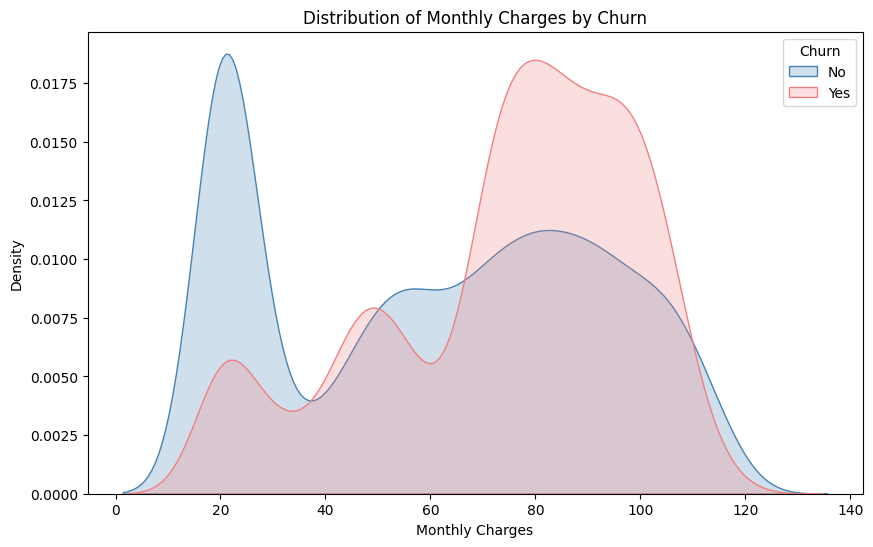

In [148]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df[df['Churn'] == 0],
            x='MonthlyCharges',
            label='No',
            color='steelblue',
            shade=True)
sns.kdeplot(data=df[df['Churn'] == 1],
            x='MonthlyCharges',
            label='Yes',
            color='lightcoral',
            shade=True)
plt.title('Distribution of Monthly Charges by Churn')
plt.xlabel('Monthly Charges')
plt.ylabel('Density')
plt.legend(title='Churn')
plt.show()


- Higher monthly charges are correlated with a higher likelihood of churn.
- There is overlap in the mid-to-high range (50 to 100), indicating that monthly charges alone don't fully determine churn, but they’re clearly associated.

<ipython-input-152-823ba43049c5>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y='tenure', data=df, palette=['steelblue', 'lightcoral'])


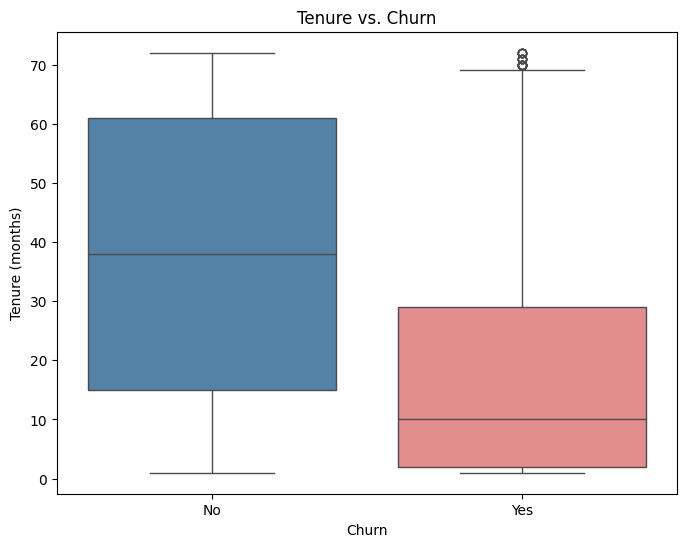

In [152]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Churn', y='tenure', data=df, palette=['steelblue', 'lightcoral'])
plt.title('Tenure vs. Churn')
plt.xlabel('Churn')
plt.ylabel('Tenure (months)')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

### Churn = Yes

- These customers tend to have much longer tenures.

- The median tenure is around 37–38 months.

- Most of them have been with the company for 15 to 60+ months, with some even beyond 70.

### Churn = No

- Customers who churned generally had much shorter tenures.

- The median is around 10 months.

- A large portion of churn happens within the first 30 months.

### Outliers

- Some customers who churned stayed a long time (over 60 months), but they are rare cases.

##5.2 Heatmap

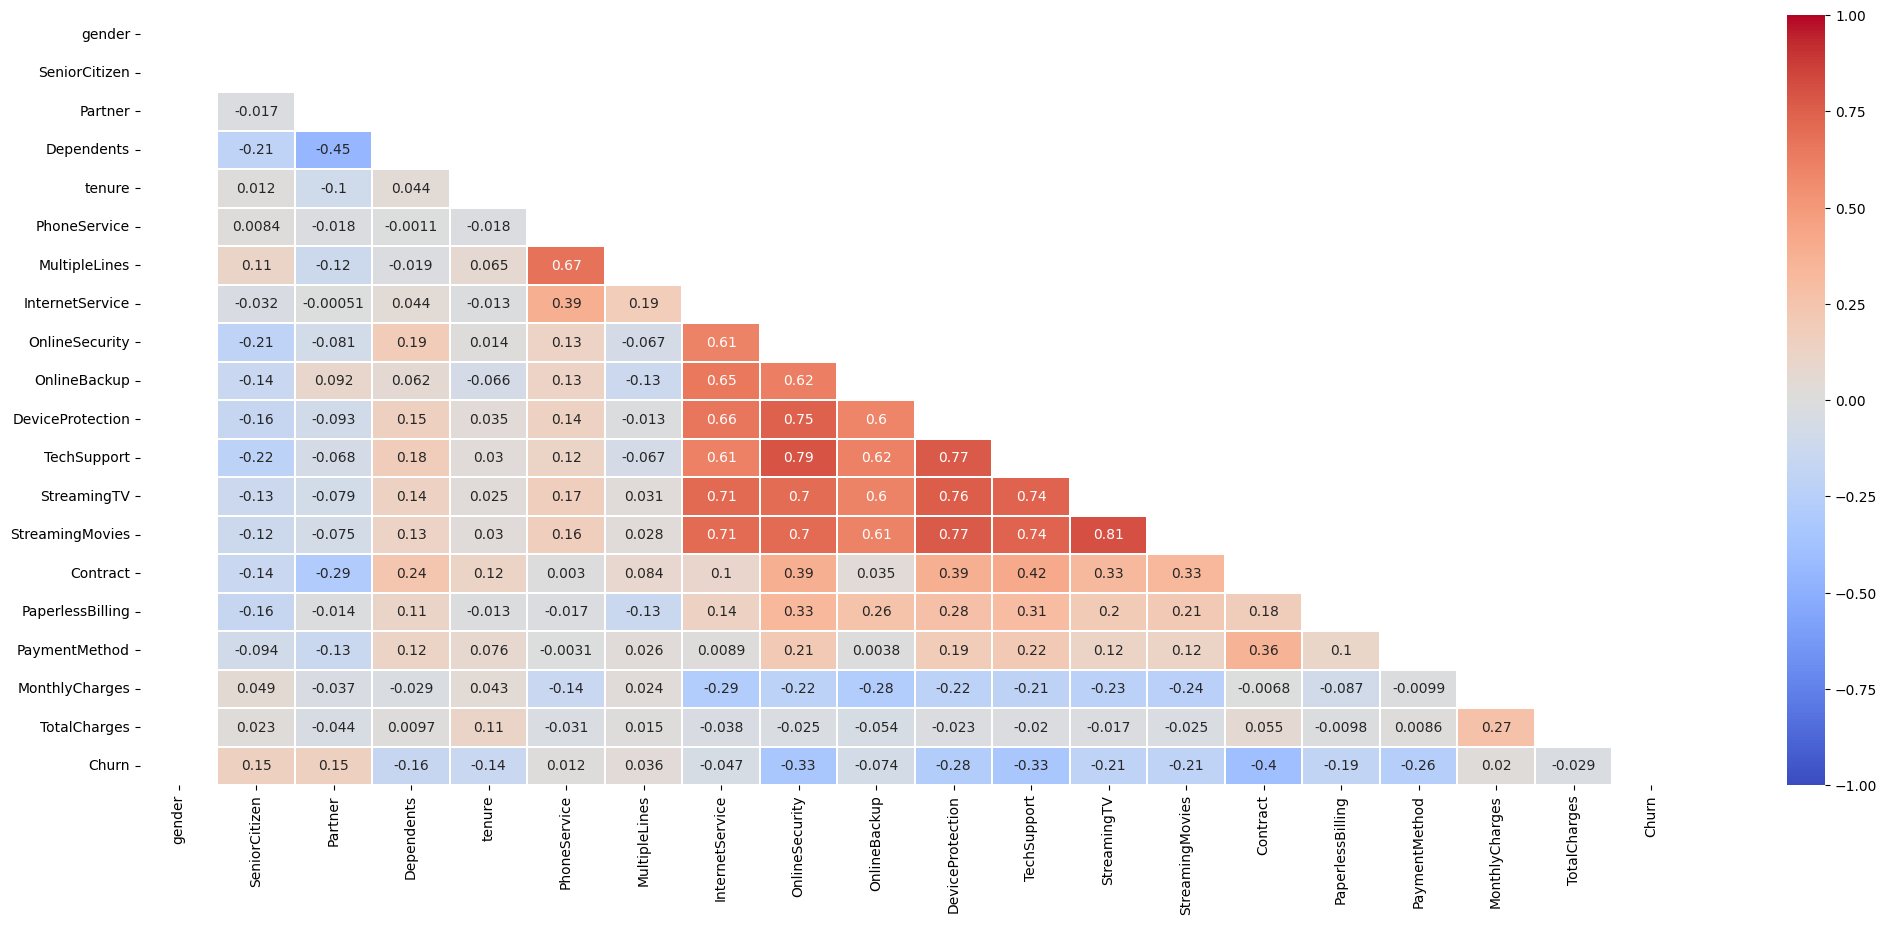

In [164]:
plt.figure(figsize=(25, 10))

# This part converts categorical features (like "Yes" or "No") into numerical representations using pd.factorize. This is important because correlation calculations require numerical data.
corr = df.apply(lambda x: pd.factorize(x)[0]).corr()

# This creates a mask to hide the upper triangle of the heatmap. Heatmaps are often symmetrical, and showing only the lower triangle avoids redundancy and improves clarity.
mask = np.triu(np.ones_like(corr, dtype=bool))

hm = sns.heatmap(corr, mask=mask, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, linewidths=.2, cmap='coolwarm', vmin=-1, vmax=1)

Key Insights:
- Contract (-0.40): Strongest negative correlation — customers with longer contracts churn far less.

- TechSupport & OnlineSecurity (~ -0.33): Having support and security services is associated with lower churn.

- PaymentMethod (-0.26): Some payment methods (like electronic checks) might be linked to higher churn.

- MonthlyCharges (+0.27): Higher monthly bills are modestly associated with greater churn.

#6. Data Preprocessing

In [165]:
# Seleção de features numéricas e categóricas
df.info()
num_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = df.select_dtypes(include=['object']).columns.tolist()
cat_features.remove('customerID')  # Remover ID do cliente

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            0 non-null      float64
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   object 
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032 non-null   object 
 16  PaymentMethod     7032 non-null   object 
 17  

ValueError: list.remove(x): x not in list

In [ ]:
# Transformar variáveis categóricas em dummies
df = pd.get_dummies(df, columns=cat_features, drop_first=True)

In [ ]:
df

In [ ]:
# Separar variáveis preditoras e alvo
X = df.drop(columns=['customerID', 'Churn'])
y = df['Churn']

In [ ]:
# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Normalizar os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Treinar modelo Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

In [ ]:
# Avaliar o modelo
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred))

In [ ]:
# Matriz de confusão
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

In [ ]:
# Explicabilidade do modelo
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)